In [ ]:
#CAUTION: Takes a long time to load.
install.packages("themis")
devtools::install_github("tidymodels/tune")

Warning message in install.packages("themis"):
“installation of package ‘themis’ had non-zero exit status”
Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [22]:
#load libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(themis)
options(repr.matrix.max.rows = 10)

In [23]:
#Add columns
unscaled_data <- read_csv("pulsar_data.csv", 
                        col_names = c("mean_integrated_profile", 
                                      "stand_dev_integrated_profile", 
                                      "exc_kurtosis_integrated_profile", 
                                      "skew_integrated_profile",
                                      "mean_dmsnr", 
                                      "stand_dev_dmsnr", 
                                      "exc_kurtosis_dmsnr", 
                                      "skew_dmsnr", "class")) 

unscaled_data <- unscaled_data |>
    mutate(class = as_factor(class))
#unscaled_data 

#Class proportions in pulsar dataset (Imbalanced)
num_obs <- nrow(unscaled_data)
pulsar_proportions <- unscaled_data |>
    group_by(class) |>
    summarize(n = n()) |>
    mutate(percent = 100*n/nrow(unscaled_data))
pulsar_proportions

#Scale data and Upsample to balance data
pulsar_recipe <- recipe(class ~ ., data = unscaled_data) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    step_upsample(class, over_ratio = 1, skip = FALSE) |>
    prep()

standardized_pulsar <- bake(pulsar_recipe, unscaled_data)
standardized_pulsar

#check proportions of upsampled data
new_pulsar_proportions <- standardized_pulsar |>
    group_by(class) |>
    summarize(n = n()) |>
    mutate(percent = 100*n/nrow(standardized_pulsar))
new_pulsar_proportions

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): mean_integrated_profile, stand_dev_integrated_profile, exc_kurtosis...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


class,n,percent
<fct>,<int>,<dbl>
0,16259,90.842552
1,1639,9.157448


mean_integrated_profile,stand_dev_integrated_profile,exc_kurtosis_integrated_profile,skew_integrated_profile,mean_dmsnr,stand_dev_dmsnr,exc_kurtosis_dmsnr,skew_dmsnr,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1.1492849,1.3347944,-0.66955083,-0.4004478,-0.3194313,-0.3706151,-0.07279575,-0.2874301,0
-0.3341589,1.8022150,-0.01178443,-0.3705251,-0.3710915,-0.5889076,0.50441285,0.2115755,0
-0.3143634,-1.0532928,-0.14522850,-0.1165896,-0.3220980,-0.2353216,-0.12599257,-0.3913625,0
1.0006664,1.5532110,-0.51339427,-0.3901672,-0.3043957,-0.2756588,-0.31225666,-0.4812869,0
-0.8713781,-0.8588548,0.11560548,-0.1048632,-0.3879995,-0.7630898,1.32398915,1.3867553,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
-3.172223,-2.5335244,5.301855,6.488476,2.1203704,2.432440,-1.661591,-0.9870469,1
-2.581709,-2.0642483,3.049599,2.608256,2.2779326,2.536356,-1.699247,-0.9903347,1
-2.635613,-1.4922772,2.835443,2.085346,2.8116410,2.903726,-1.790218,-0.9959803,1


class,n,percent
<fct>,<int>,<dbl>
0,16259,50
1,16259,50


In [24]:
set.seed(1)
pulsar_split <- initial_split(standardized_pulsar, prop = 0.75, strata = class)
pulsar_train <- training(pulsar_split)
pulsar_test <- testing(pulsar_split) 

pulsar_recipe <- recipe(class ~ ., data = standardized_pulsar)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
    set_engine("kknn") |>
    set_mode("classification")

pulsar_fit <- workflow() |>
    add_recipe(pulsar_recipe) |>
    add_model(knn_spec) |>
    fit(data = pulsar_train)
pulsar_fit

pulsar_test_predictions <- predict(pulsar_fit, pulsar_test) |>
    bind_cols(pulsar_test)
pulsar_test_predictions

pulsar_prediction_accuracy <- pulsar_test_predictions |>
    metrics(truth = class, estimate = .pred_class) |>
    filter(.metric == "accuracy")
pulsar_prediction_accuracy

confusion <- pulsar_test_predictions |>
    conf_mat(truth = class, estimate = .pred_class)
confusion

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(3,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.0174266
Best kernel: rectangular
Best k: 3

.pred_class,mean_integrated_profile,stand_dev_integrated_profile,exc_kurtosis_integrated_profile,skew_integrated_profile,mean_dmsnr,stand_dev_dmsnr,exc_kurtosis_dmsnr,skew_dmsnr,class
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0,1.14928492,1.3347944,-0.66955083,-0.4004478,-0.3194313,-0.3706151,-0.07279575,-0.2874301,0
0,-0.33415887,1.8022150,-0.01178443,-0.3705251,-0.3710915,-0.5889076,0.50441285,0.2115755,0
0,1.20836685,-0.1843379,-0.75014651,-0.2409772,-0.2455865,0.1378174,-0.49428426,-0.6292692,0
0,0.86453436,-0.3640536,-0.52527844,-0.2683108,-0.3726235,-0.7354026,0.81412244,0.8513931,0
0,-0.05610833,0.3606682,-0.31974505,-0.3286328,-0.3768221,-0.7320593,1.12389396,1.1132819,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1,-0.579623,0.1476754,0.09901916,-0.2389543,0.1819930,1.596178,-1.159821,-0.9101226,1
1,-2.080426,-0.9888789,1.90721038,1.2482890,1.8660128,3.228820,-1.668233,-0.9940773,1
1,-3.172223,-2.5335244,5.30185505,6.4884765,2.1203704,2.432440,-1.661591,-0.9870469,1


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9824108


          Truth
Prediction    0    1
         0 3926    4
         1  139 4061

In [25]:
#10 fold cross validation
pulsar_vfold <- vfold_cv(pulsar_train, v = 10, strata = class)

pulsar_resample_fit <- workflow() |>
       add_recipe(pulsar_recipe) |>
       add_model(knn_spec) |>
       fit_resamples(resamples = pulsar_vfold)

pulsar_metrics <- collect_metrics(pulsar_resample_fit)
pulsar_metrics

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,binary,0.9808927,10,0.0006686887,Preprocessor1_Model1
roc_auc,binary,0.9890878,10,0.0004404272,Preprocessor1_Model1


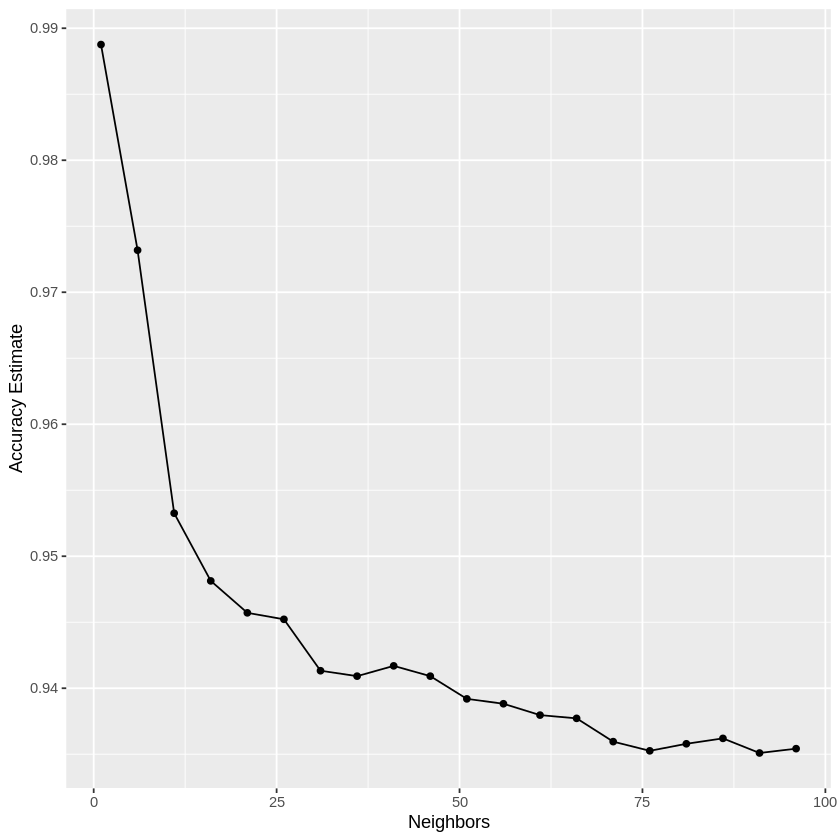

In [26]:
#CAUTION: Takes a long time to load.
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")
#knn_tune

k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

knn_results <- workflow() |>
               add_recipe(pulsar_recipe) |>
               add_model(knn_tune) |>
               tune_grid(resamples = pulsar_vfold, grid = k_vals) |>
               collect_metrics()
#knn_results

accuracies <- knn_results |> 
       filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate")  



accuracy_versus_k


In [27]:
#we can have a separate cell for each combination of predictors that we try
#pick one K value to use for all the combinations, to avoid having to find the best K each time (which could vary)
#we could call the predictor combinations combo1, combo2, etc.
#compare their accuracies, choose the most accurate set of predictors
#Read Chapter 6.8 on selecting good predictors.

**Selecting Predictors**

In [32]:
names <- colnames(pulsar_train |> select(-class))
names

[1] "mean_integrated_profile"         "stand_dev_integrated_profile"   
[3] "exc_kurtosis_integrated_profile" "skew_integrated_profile"        
[5] "mean_dmsnr"                      "stand_dev_dmsnr"                
[7] "exc_kurtosis_dmsnr"              "skew_dmsnr"

In [29]:
example_formula <- paste("class", "~", paste(names, collapse="+"))
example_formula

[1] "class ~ mean_integrated_profile+stand_dev_integrated_profile+exc_kurtosis_integrated_profile+skew_integrated_profile+mean_dmsnr+stand_dev_dmsnr+exc_kurtosis_dmsnr+skew_dmsnr"

In [30]:
# create an empty tibble to store the results
predictor_accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

In [31]:
# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("class", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        pulsar_recipe <- recipe(as.formula(model_string), 
                                data = pulsar_train) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() |>
          add_recipe(pulsar_recipe) |>
          add_model(knn_spec) |>
          tune_grid(resamples = pulsar_vfold, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
predictor_accuracies <- predictor_accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
predictor_accuracies

Warning message:
“No tuning parameters have been detected, performance will be evaluated using the resamples with no tuning. Did you want to [tune()] parameters?”
Warning message:
“No tuning parameters have been detected, performance will be evaluated using the resamples with no tuning. Did you want to [tune()] parameters?”
Warning message:
“No tuning parameters have been detected, performance will be evaluated using the resamples with no tuning. Did you want to [tune()] parameters?”
Warning message:
“No tuning parameters have been detected, performance will be evaluated using the resamples with no tuning. Did you want to [tune()] parameters?”
Warning message:
“No tuning parameters have been detected, performance will be evaluated using the resamples with no tuning. Did you want to [tune()] parameters?”
Warning message:
“No tuning parameters have been detected, performance will be evaluated using the resamples with no tuning. Did you want to [tune()] parameters?”
Warning message:
“No t

size,model_string,accuracy
<int>,<chr>,<dbl>
1,class ~ exc_kurtosis_integrated_profile,0.9749051
2,class ~ exc_kurtosis_integrated_profile+skew_dmsnr,0.9792116
3,class ~ exc_kurtosis_integrated_profile+skew_dmsnr+stand_dev_integrated_profile,0.9810161
4,class ~ exc_kurtosis_integrated_profile+skew_dmsnr+stand_dev_integrated_profile+mean_dmsnr,0.9813030
5,class ~ exc_kurtosis_integrated_profile+skew_dmsnr+stand_dev_integrated_profile+mean_dmsnr+skew_integrated_profile,0.9814259
6,class ~ exc_kurtosis_integrated_profile+skew_dmsnr+stand_dev_integrated_profile+mean_dmsnr+skew_integrated_profile+exc_kurtosis_dmsnr,0.9815489
7,class ~ exc_kurtosis_integrated_profile+skew_dmsnr+stand_dev_integrated_profile+mean_dmsnr+skew_integrated_profile+exc_kurtosis_dmsnr+mean_integrated_profile,0.9813028
8,class ~ exc_kurtosis_integrated_profile+skew_dmsnr+stand_dev_integrated_profile+mean_dmsnr+skew_integrated_profile+exc_kurtosis_dmsnr+mean_integrated_profile+stand_dev_dmsnr,0.9808927


Based on the data above, the highest accuracy obtained by having exc_kurtosis_integrated_profile+skew_dmsnr+stand_dev_integrated_profile+mean_dmsnr+skew_integrated_profile+exc_kurtosis_dmsnr as predictors